In [ ]:
!pip install lazypredict scikit-learn --quiet

In [2]:
import pandas as pd
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import train_test_split

In [12]:
df = pd.read_csv(r"uscecchini28.csv")
df.tail()

,fyear,gvkey,sich,insbnk,understatement,option,p_aaer,new_p_aaer,misstate,act,...,soft_assets,ch_cs,ch_cm,ch_roa,issue,bm,dpi,reoa,EBIT,ch_fcf
146040,2014,314866,8200.00,0,0,0,NaN,NaN,0,262.60,...,0.75,0.56,0.13,-0.05,1,0.10,0.83,-0.33,-0.01,-0.26
146041,2014,315318,2890.00,0,0,0,NaN,NaN,0,1578.40,...,0.74,-0.12,0.03,0.10,1,0.58,0.74,-0.08,0.00,-0.30
146042,2014,316056,3420.00,0,0,0,NaN,NaN,0,973.80,...,0.75,0.00,-0.04,0.07,1,-0.00,1.06,-0.00,0.15,0.07
146043,2014,317260,4412.00,0,0,0,NaN,NaN,0,51.74,...,0.02,NaN,NaN,NaN,1,1.11,NaN,0.00,0.03,NaN
146044,2014,317264,4412.00,0,0,0,NaN,NaN,0,233.21,...,0.07,1.68,-0.09,0.02,1,1.15,0.75,0.03,0.03,-0.24


In [13]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from scipy.stats import chisquare

# --- raw variables and Benford's theoretical probabilities ---
raw_variables = ['at', 'ap', 'ceq', 'che', 'csho', 'dltt', 'dp', 'ni', 'ppegt',
                  'pstk', 're', 'rect', 'sale', 'lt', 'xint', 'ivao', 'dltis', 'sstk']

# Theoretical probabilities for digits 1-9
benford_probs = np.array([np.log10(1 + 1 / d) for d in range(1, 10)])

# --- function to calculate the Benford's Law Chi-squared statistic for a row ---
def calculate_benford_chi2(row):
    """Calculates the Chi-squared statistic for a given row based on Benford's Law."""

    # Extract first digits from the row's variables, excluding NaNs and zeros
    first_digits = [
        int(str(abs(x))[0]) for x in row[raw_variables]
        if pd.notna(x) and x != 0
    ]

    if not first_digits:
        return np.nan

    # Count the occurrences of each digit
    digit_counts = pd.Series(first_digits).value_counts().sort_index()

    # Create an observed counts array for all 9 digits
    observed = np.zeros(9)
    for i, count in digit_counts.items():
        if 1 <= i <= 9:
            observed[i-1] = count

    # Expected counts based on Benford's Law
    n = len(first_digits)
    expected = benford_probs * n

    # Calculate Chi-squared statistic, handling zero values
    expected_safe = expected + 1e-10
    chi2_stat = np.sum((observed - expected)**2 / expected_safe)

    return chi2_stat

# --- Add the new feature column to the DataFrame ---
df['benford_chi2'] = df.apply(calculate_benford_chi2, axis=1)

y = df['misstate']

# Drop Fraud-Specific Labels
X = df.drop(['misstate','p_aaer','new_p_aaer','understatement'], axis=1)
X = X[['at', 'ap', 'ceq', 'che', 'csho', 'dltt', 'dp', 'ni', 'ppegt', 'pstk',
      're', 'rect', 'sale', 'lt', 'xint', 'ivao', 'ch_rsst', 'dch_rec', 'ch_cs',
       'ch_cm', 'ch_roa', 'dpi', 'reoa', 'dltis', 'sstk', 'issue', 'ch_fcf', 'benford_chi2']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


964 145081
Kolmogorov-Smirnov Test Results:
KS Statistic: 0.0397
P-value: 0.0945

Based on the p-value, we cannot reject the null hypothesis.
The two distributions are not statistically different.


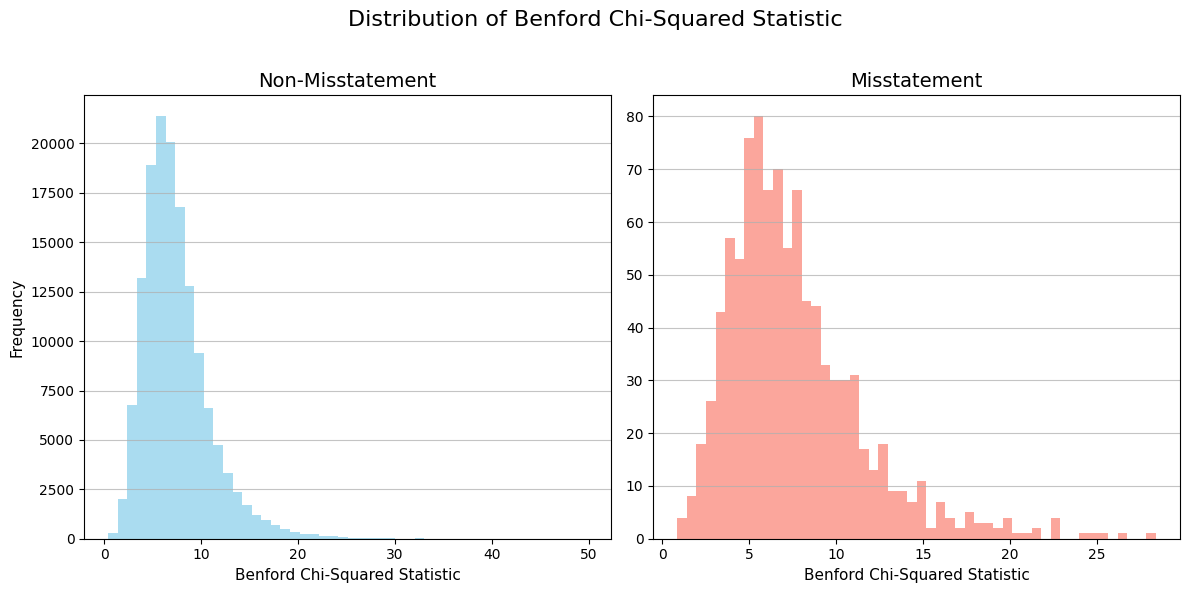

In [45]:
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

misstatement_df = df[df['misstate'] == 1]['benford_chi2']
non_misstatement_df = df[df['misstate'] == 0]['benford_chi2']
print(len(misstatement_df), len(non_misstatement_df))

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot the histogram for non-misstatement
axes[0].hist(non_misstatement_df, bins=50, color='skyblue', alpha=0.7)
axes[0].set_title('Non-Misstatement', fontsize=14)
axes[0].set_xlabel('Benford Chi-Squared Statistic', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(axis='y', alpha=0.75)

# Plot the histogram for misstatement
axes[1].hist(misstatement_df, bins=50, color='salmon', alpha=0.7)
axes[1].set_title('Misstatement', fontsize=14)
axes[1].set_xlabel('Benford Chi-Squared Statistic', fontsize=11)
axes[1].grid(axis='y', alpha=0.75)

plt.suptitle('Distribution of Benford Chi-Squared Statistic', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('benford_chi2_side_by_side.png')

# Perform a statistical test (Kolmogorov-Smirnov test)
# The KS test checks if two samples are drawn from the same continuous distribution.
# H0 (Null Hypothesis): The two distributions are the same.
# H1 (Alternative Hypothesis): The two distributions are different.
ks_statistic, p_value = ks_2samp(non_misstatement_df, misstatement_df)

print(f"Kolmogorov-Smirnov Test Results:")
print(f"KS Statistic: {ks_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("\nBased on the p-value, we can reject the null hypothesis.")
    print("The two distributions are statistically different.")
else:
    print("\nBased on the p-value, we cannot reject the null hypothesis.")
    print("The two distributions are not statistically different.")

In [36]:
X_train.head()


,at,ap,ceq,che,csho,dltt,dp,ni,ppegt,pstk,...,ch_cs,ch_cm,ch_roa,dpi,reoa,dltis,sstk,issue,ch_fcf,benford_chi2
118582,14.82,2.94,7.38,0.34,8.93,0.00,1.04,-4.63,13.17,0.00,...,0.13,-0.20,0.22,1.00,-0.69,0.00,0.01,1,0.49,9.16
56382,37.70,7.36,1.68,6.44,17.11,0.36,4.07,-5.15,21.97,0.00,...,0.20,-0.32,-0.09,0.94,-2.02,0.00,0.08,1,-0.02,4.18
23392,10.83,1.40,5.41,0.00,6.38,0.00,1.33,-3.10,18.10,0.00,...,-0.28,-0.36,-0.17,1.08,-0.63,8.95,0.00,1,0.01,7.32
115983,18.18,0.61,8.68,0.70,8.37,6.74,0.94,0.00,24.00,0.00,...,-0.43,0.03,-0.04,1.84,0.26,5.10,0.00,1,0.00,5.99
70684,14669.84,745.27,7271.36,2502.71,735.47,2255.09,1309.80,2990.72,15651.28,0.00,...,-0.20,-0.33,0.06,0.86,0.35,3.62,0.00,1,-0.14,7.03


In [ ]:
from lazypredict.Supervised import CLASSIFIERS
print(CLASSIFIERS)

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('FixedThresholdClassifier', <class 'sklearn.model_selection._classification_threshold.FixedThresholdClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._

In [ ]:
from lazypredict.Supervised import LazyClassifier
from xgboost import XGBClassifier, XGBRFClassifier, XGBRFRegressor
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble._weight_boosting import AdaBoostClassifier
from sklearn.ensemble._bagging import BaggingClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.metrics import f1_score

def custom_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted')

# Pass the classifier classes directly in a list.
selected_classifiers = [XGBClassifier, DecisionTreeClassifier, ExtraTreeClassifier,
                        AdaBoostClassifier, BaggingClassifier, XGBRFClassifier,
                        GaussianNB, CategoricalNB, BernoulliNB, ]

clf = LazyClassifier(predictions=True, classifiers=selected_classifiers, custom_metric=custom_f1)
models, predictions = clf.fit(X_train_scaled, X_test_scaled, y_train, y_test)

In [38]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,custom_f1,Time Taken
Model,,,,,,
DecisionTreeClassifier,0.99,0.54,0.54,0.99,0.99,7.88
XGBRFClassifier,0.99,0.54,0.54,0.99,0.99,2.24
BernoulliNB,0.88,0.54,0.54,0.93,0.93,0.22
ExtraTreeClassifier,0.99,0.53,0.53,0.99,0.99,0.24
GaussianNB,0.96,0.52,0.52,0.97,0.97,0.19
XGBClassifier,0.99,0.51,0.51,0.99,0.99,2.60
BaggingClassifier,0.99,0.51,0.51,0.99,0.99,62.90
AdaBoostClassifier,0.99,0.50,0.50,0.99,0.99,28.44


In [53]:
import yfinance as yf
import pandas as pd

def get_fraud_variables_and_ratios(ticker_symbol):
    """
    Downloads financial data from yfinance and calculates a subset of variables
    and ratios from the uscecchini28 accounting fraud dataset.

    Args:
        ticker_symbol (str): The ticker symbol for the company on Yahoo Finance.

    Returns:
        dict: A dictionary containing the extracted raw variables and calculated
              ratios. Returns None if data retrieval fails or is insufficient.
    """
    try:
        # 1. Download the data from yfinance
        stock = yf.Ticker(ticker_symbol)
        balance_sheet = stock.balance_sheet
        income_statement = stock.financials
        cash_flow = stock.cash_flow

        # Transpose the DataFrames for easier year-over-year calculations
        bs_T = balance_sheet.T
        is_T = income_statement.T
        ca_T = cash_flow.T

    except Exception as e:
        print(f"Error: Could not retrieve data for {ticker_symbol}. Details: {e}")
        return None

    # Check for sufficient data
    if len(bs_T.columns) < 2 or len(is_T.columns) < 2:
        print("Error: Insufficient data to perform year-over-year calculations.")
        return None

    # Extract the most recent two years of data
    bs_2024 = bs_T.iloc[0]
    bs_2023 = bs_T.iloc[1]
    is_2024 = is_T.iloc[0]
    is_2023 = is_T.iloc[1]
    ca_2024 = ca_T.iloc[0]
    ca_2023 = ca_T.iloc[1]

    # Dictionary to store the extracted variables and calculated ratios
    results = {}

    # --- 2. Extracting Raw Variables ---
    try:
        # Mappings from uscecchini28 dataset to yfinance names
        #results['fyear'] = bs_2024.name.year
        results['at'] = bs_2024.get('Total Assets')
        results['ap'] = bs_2024.get('Accounts Payable')
        results['ceq'] = bs_2024.get('Common Stock Equity')
        results['che'] = bs_2024.get('Cash And Cash Equivalents')
        results['csho'] = bs_2024.get('Ordinary Shares Number')
        results['dltt'] = bs_2024.get('Long Term Debt And Capital Lease Obligation')
        results['dp'] = is_2024.get('Reconciled Depreciation')
        results['ni'] = is_2024.get('Net Income Common Stockholders')
        results['ppegt'] = bs_2024.get('Gross PPE')
        results['pstk'] = bs_2024.get('Preferred Stock')
        results['re'] = bs_2024.get('Retained Earnings')
        results['rect'] = bs_2024.get('Receivables')
        results['sale'] = is_2024.get('Total Revenue')
        results['lt'] = bs_2024.get('Total Liabilities Net Minority Interest')
        results['xint'] = is_2024.get('Interest Expense')
        results['ivao'] = bs_2024.get('Investments And Advances')

    except Exception as e:
        print(f"Error during variable extraction. Please check if the expected columns exist: {e}")
        return None

    # --- 3. Calculating the 7 Ratios ---
    try:
        # ch_rsst: Change in Revenue and Receivable
        results['ch_rsst'] = ((results['sale'] - results['rect']) /
                              (is_2023.get('Total Revenue') - bs_2023.get('Receivables')))

        # dch_rec: Change in Receivables
        results['dch_rec'] = (results['rect'] - bs_2023.get('Receivables')) / bs_2023.get('Total Assets')

        # ch_cs: Change in Common Stock
        results['ch_cs'] = (results['csho'] - bs_2023.get('Ordinary Shares Number')) / bs_2023.get('Ordinary Shares Number')

        # ch_cm: Change in Cash and Marketable Securities
        results['ch_cm'] = ((results['che'] + bs_2024.get('Cash Equivalents')) -
                            (bs_2023.get('Cash And Cash Equivalents') + bs_2023.get('Cash Equivalents'))) / results['at']

        # ch_roa: Change in Return on Assets
        roa_2024 = results['ni'] / results['at']
        roa_2023 = is_2023.get('Net Income Common Stockholders') / bs_2023.get('Total Assets')
        results['ch_roa'] = roa_2024 - roa_2023

        # dpi: Change in Gross Property, Plant, and Equipment
        results['dpi'] = (results['ppegt'] - bs_2023.get('Gross PPE')) / bs_2023.get('Gross PPE')

        # reoa: Retained Earnings to Assets
        results['reoa'] = results['re'] / results['at']

        results['dltis'] = ca_2024['Long Term Debt Issuance']
        results['sstk'] = ca_2024['Issuance Of Capital Stock']

        results['issue'] = results['sstk'] / results['at']
        fcf_2024 = ca_2024['Free Cash Flow']
        fcf_2023 = ca_2023['Free Cash Flow']
        results['ch_fcf'] = (fcf_2024 - fcf_2023) / results['at']

    except (KeyError, ZeroDivisionError) as e:
        print(f"Error during ratio calculation: {e}")
        return None

    return results

# Example usage
ticker_symbol = "GARAN.IS"
extracted_data = get_fraud_variables_and_ratios(ticker_symbol)
ticker_df = pd.DataFrame(extracted_data, index=[0])
# --- Add the new benford_chi2 column to ticker DataFrame ---
ticker_df['benford_chi2'] = ticker_df.apply(calculate_benford_chi2, axis=1)
ticker_df_scaled = scaler.transform(ticker_df)

if extracted_data:
    print(f"\n--- Extracted Variables and Calculated Ratios for {ticker_symbol} ---")
    for key, value in extracted_data.items():
        print(f"{key}: {value}")


--- Extracted Variables and Calculated Ratios for GARAN.IS ---
at: 3002579379000.0
ap: 110694236000.0
ceq: 329788449000.0
che: 591842159000.0
csho: 4200000000.0
dltt: 223968733000.0
dp: 3707320000.0
ni: 91243136000.0
ppegt: 47007468000.0
pstk: 0.0
re: 91279430000.0
rect: 57810685000.0
sale: 287168372000.0
lt: 2671170761000.0
xint: 414500152000.0
ivao: 314455248000.0
ch_rsst: 1.3685703597166776
dch_rec: 0.011843472275846187
ch_cs: 0.0
ch_cm: 0.039579443538168654
ch_roa: -0.008842562979160501
dpi: 0.5988956447559792
reoa: 0.030400338668282047
dltis: 154717733000.0
sstk: 0.0
issue: 0.0
ch_fcf: -0.11370871804019007


In [ ]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(scale_pos_weight)

model_1 = XGBClassifier(scale_pos_weight=scale_pos_weight)
model_1.fit(X_train_scaled, y_train)

model_2 = XGBRFClassifier(scale_pos_weight=scale_pos_weight)
model_2.fit(X_train_scaled, y_train)

In [54]:
for m in [model_1, model_2]:
    prediction = m.predict(ticker_df_scaled)
    prediction_proba = m.predict_proba(ticker_df_scaled)

    print(f"\n--- Prediction for GARAN.IS ---")
    if prediction[0] == 1:
        print("The model predicts this is a FRAUDULENT financial statement.")
    else:
        print("The model predicts this is a NON-FRAUDULENT financial statement.")

    print(f"Fraud Probability: {prediction_proba[0][1]:.2f}")



--- Prediction for GARAN.IS ---
The model predicts this is a NON-FRAUDULENT financial statement.
Fraud Probability: 0.06

--- Prediction for GARAN.IS ---
The model predicts this is a FRAUDULENT financial statement.
Fraud Probability: 0.57
